---
# Twitter Sentiment Analysis for Hub Cities
---

Files needed:
* twitter_keys.py
* prepare_tweets.py
* explore_tweets.py

In [1]:
!mkdir data

mkdir: data: File exists


---
## Set up Twitter API

In [2]:
!pip install twitter --quiet # install twitter module
from twitter_keys import API_key, API_key_secret, access_token, access_token_secret # import API access tokens from file to keep them hidden from notebook
import twitter # twitter nodule
from urllib.parse import unquote # used to clean up urls
import time # needed to rate limiting from twitter API

# create variables to hold tokens
CONSUMER_KEY = API_key
CONSUMER_SECRET = API_key_secret
OAUTH_TOKEN = access_token
OAUTH_TOKEN_SECRET = access_token_secret

# create variable to hold OAuth info
auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)

# create twitter api object
twitter_api = twitter.Twitter(auth=auth)

---
## Set up Spark Session

In [3]:
!pip install pyspark --quiet
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark

---
## Other Imports

In [4]:
import json
import prepare_tweets as p
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, DoubleType
import pandas as pd
import explore_tweets as e
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import nltk.sentiment as sent
import nltk
nltk.download('vader_lexicon')

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')
sns.set_palette('ocean_r')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adamtalbot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/adamtalbot/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


---
## Get Tweet Data

In [5]:
def get_full_tweets(q, geocode, count=100, lang='en', tweet_mode='extended'):
  ''' Uses Twitter API to get tweets based on keyword, count per page, language, and geocode'''

  # do first search
  search_results = twitter_api.search.tweets(q=q, count=count, lang=lang, geocode=geocode, tweet_mode=tweet_mode)

  # pull out statuses and save to variable
  statuses = search_results['statuses']

  # Iterate through more batches of results by following the cursor using for loop
  counter = 1
  while True:
      # print(counter)
      counter += 1
      # print('Length of statuses', len(statuses))
      try:
          next_results = search_results['search_metadata']['next_results']
      except: # No more results when next_results doesn't exist
          break
          
      # Create a dictionary from next_results, which has the following form:
      # ?max_id=847960489447628799&q=%23RIPSelena&count=100&include_entities=1
      kwargs = dict([args.split('=') for args in unquote(next_results[1:]).split("&") ])
      
      search_results = twitter_api.search.tweets(**kwargs, tweet_mode=tweet_mode)
      
      statuses += search_results['statuses']
      
  print(f'Total Number of Requests: {counter}')
  print(f'Total Number of Tweets Collected: {len(statuses)}')
  return(statuses)

In [6]:
# create and set values for parameters
q = 'covid'
geocode_phoenix = '33.4484,-112.074,50mi'
geocode_tampa = '27.9506,-82.4572,50mi'
geocode_dfw = '32.7079,-96.9209,50mi'

In [7]:
# call function for each city
phoenix_tweets_full = get_full_tweets(q=q, geocode=geocode_phoenix)

Total Number of Requests: 23
Total Number of Tweets Collected: 2019


In [8]:
tampa_tweets_full = get_full_tweets(q=q, geocode=geocode_tampa)

Total Number of Requests: 24
Total Number of Tweets Collected: 2167


In [9]:
dfw_tweets_full = get_full_tweets(q=q, geocode=geocode_dfw)

Total Number of Requests: 103
Total Number of Tweets Collected: 10044


In [10]:
# # may need to use this if rate limiting stop requests (depends on number of tweets in past 7 days at time of execution)
# # need to write try except logic to account for both scenarios
# def acquire_full_tweets(q, geocode_phoenix, geocode_tampa, geocode_dfw):
#   phoenix_tweets_full = get_full_tweets(q=q, geocode=geocode_phoenix)
#   tampa_tweets_full = get_full_tweets(q=q, geocode=geocode_tampa)
#   time.sleep(930)
#   dfw_tweets_full = get_full_tweets(q=q, geocode=geocode_dfw)
#   return phoenix_tweets_full, tampa_tweets_full, dfw_tweets_full

In [11]:
# # function to get all new data with necessary pause
# phoenix_tweets, tampa_tweets, dfw_tweets = acquire_full_tweets(q, geocode_phoenix, geocode_tampa, geocode_dfw)

In [12]:
# check to make sure files are what I want
print(len(phoenix_tweets_full))
print(len(tampa_tweets_full))
print(len(dfw_tweets_full))

2019
2167
10044


In [13]:
def filter_tweet_columns(tweet_list):
  tweets_final_full = []
  for tweet in tweet_list:
    new_tweet = {
        'created_at' : tweet['created_at'],
        'full_text' : tweet['full_text'],
        # 'favorite_count' : tweet['favorite_count'],
        # 'retweet_count' : tweet['retweet_count']
                } 
    tweets_final_full.append(new_tweet)
  return tweets_final_full

In [14]:
phoenix_tweets_final_full = filter_tweet_columns(phoenix_tweets_full)
tampa_tweets_final_full = filter_tweet_columns(tampa_tweets_full)
dfw_tweets_final_full = filter_tweet_columns(dfw_tweets_full)

In [15]:
print(len(phoenix_tweets_final_full))
print(len(tampa_tweets_final_full))
print(len(dfw_tweets_final_full))

2019
2167
10044


In [16]:
time_stamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [17]:
time_stamp

'2022-03-01_21-24-03'

In [18]:
# with open(f'{time_stamp}_phoenix.json', 'w') as fout:
#   json.dump(phoenix_tweets_final_full, fout)

In [19]:
!mkdir 'data/{time_stamp}'

In [20]:
with open(f'data/{time_stamp}/{time_stamp}_phoenix.json', 'w') as fout:
  json.dump(phoenix_tweets_final_full, fout)

In [21]:
# with open(f'{time_stamp}_tampa.json', 'w') as fout:
#   json.dump(tampa_tweets_final_full, fout)

In [22]:
with open(f'data/{time_stamp}/{time_stamp}_tampa.json', 'w') as fout:
  json.dump(tampa_tweets_final_full, fout)

In [23]:
# with open(f'{time_stamp}_dfw.json', 'w') as fout:
#   json.dump(dfw_tweets_final_full, fout)

In [24]:
with open(f'data/{time_stamp}/{time_stamp}_dfw.json', 'w') as fout:
  json.dump(dfw_tweets_final_full, fout)

---
## Upload Data into Spark

In [25]:
# # this is an option if all one script
# phoenix_df_full = spark.createDataFrame(phoenix_tweets_final_full)
# tampa_df_full = spark.createDataFrame(tampa_tweets_final_full)
# dfw_df_full = spark.createDataFrame(dfw_tweets_final_full)

In [26]:
# # let's try reading in as json
# # would have to import timestamp from other script if separated
# phoenix_df = spark.read.json(f'{time_stamp}_phoenix.json')
# tampa_df = spark.read.json(f'{time_stamp}_tampa.json')
# dfw_df = spark.read.json(f'{time_stamp}_dfw.json')

In [27]:
# let's try reading in as json
# would have to import timestamp from other script if separated
phoenix_df = spark.read.json(f'data/{time_stamp}/{time_stamp}_phoenix.json')
tampa_df = spark.read.json(f'data/{time_stamp}/{time_stamp}_tampa.json')
dfw_df = spark.read.json(f'data/{time_stamp}/{time_stamp}_dfw.json')

#### Drop CVS Testing Notification Tweets

In [28]:
cvs_tweets = dfw_df.where(F.col('full_text').contains('COVID test available')).count()
print(f'Dropping {cvs_tweets} rows that contain CVS locations for COVID testing (noise for my analysis).')
dfw_df = dfw_df.where(~F.col('full_text').contains('COVID test available'))

Dropping 6543 rows that contain CVS locations for COVID testing (noise for my analysis).


In [29]:
phoenix_df.show(5)

+--------------------+--------------------+
|          created_at|           full_text|
+--------------------+--------------------+
|Wed Mar 02 04:14:...|@DyessRigel @hjel...|
|Wed Mar 02 04:14:...|@DonaldJTrumpJr S...|
|Wed Mar 02 04:10:...|@RenegadeofCav @k...|
|Wed Mar 02 04:08:...|@laurenboebert Sa...|
|Wed Mar 02 04:06:...|@Chuckisdope Covi...|
+--------------------+--------------------+
only showing top 5 rows



In [30]:
print(phoenix_df.count(), len(phoenix_df.columns))
print(tampa_df.count(), len(tampa_df.columns))
print(dfw_df.count(), len(dfw_df.columns))

2019 2
2167 2
3501 2


## Prepare - Clean, Tokenize, and Remove Stop Words, Create Word Count DF

In [31]:
basic_clean_udf = F.udf(p.basic_clean, StringType())

In [32]:
tok_udf = F.udf(p.tokenize, StringType())

In [33]:
stopwords_udf = F.udf(p.remove_stopwords_set, StringType())

### Phoenix

In [34]:
clean_phoenix_df = phoenix_df.withColumn('basic_clean', basic_clean_udf('full_text'))\
  .withColumn('tokenized', tok_udf('basic_clean'))\
  .withColumn('clean', stopwords_udf('tokenized'))

In [35]:
phoenix_words = ' '.join(list(clean_phoenix_df.select('clean').toPandas()['clean']))

In [36]:
phoenix_freq = pd.Series(phoenix_words.split()).value_counts()

### Tampa

In [37]:
clean_tampa_df = tampa_df.withColumn('basic_clean', basic_clean_udf('full_text'))\
  .withColumn('tokenized', tok_udf('basic_clean'))\
  .withColumn('clean', stopwords_udf('tokenized'))

In [38]:
tampa_words = ' '.join(list(clean_tampa_df.select('clean').toPandas()['clean']))

In [39]:
tampa_freq = pd.Series(tampa_words.split()).value_counts()

### DFW

In [40]:
clean_dfw_df = dfw_df.withColumn('basic_clean', basic_clean_udf('full_text'))\
  .withColumn('tokenized', tok_udf('basic_clean'))\
  .withColumn('clean', stopwords_udf('tokenized'))

In [41]:
dfw_words = ' '.join(list(clean_dfw_df.select('clean').toPandas()['clean']))

In [42]:
dfw_freq = pd.Series(dfw_words.split()).value_counts()

### All

In [43]:
all_words = ' '.join([phoenix_words, tampa_words, dfw_words])

In [44]:
all_freq = pd.Series(all_words.split()).value_counts()

In [45]:
word_counts = pd.concat([phoenix_freq, tampa_freq, dfw_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['Phoenix', 'Tampa', 'DFW', 'All']
word_counts.head()

,Phoenix,Tampa,DFW,All
people,211,177,331,719
get,156,152,304,612
like,153,154,228,535
dont,142,119,179,440
us,138,138,222,498


In [46]:
word_counts.shape

(19066, 4)

## Visualizations

### Tweet Count By City

Text(0, 0.5, '')

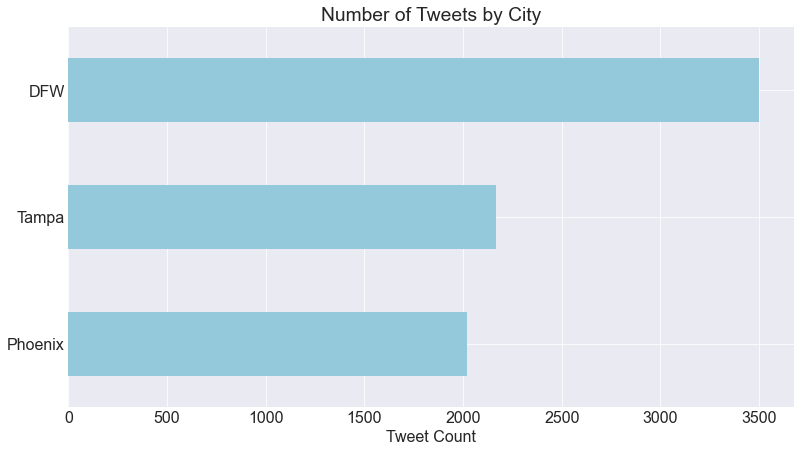

In [47]:
tweet_count = [phoenix_df.count(), tampa_df.count(), dfw_df.count()]
count_labels = ['Phoenix', 'Tampa', 'DFW']
tweet_count_zip = list(zip(count_labels, tweet_count))
tweet_count_df = pd.DataFrame(tweet_count_zip, columns=['city', 'tweet_count']).set_index('city')
tweet_count_df.tweet_count.sort_values().plot.barh()
plt.title('Number of Tweets by City')
plt.xlabel('Tweet Count')
plt.ylabel('');
# plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '{:.0f}k'.format(x / 1_000)));

### Words Counts and Proportion of Total for All Cities

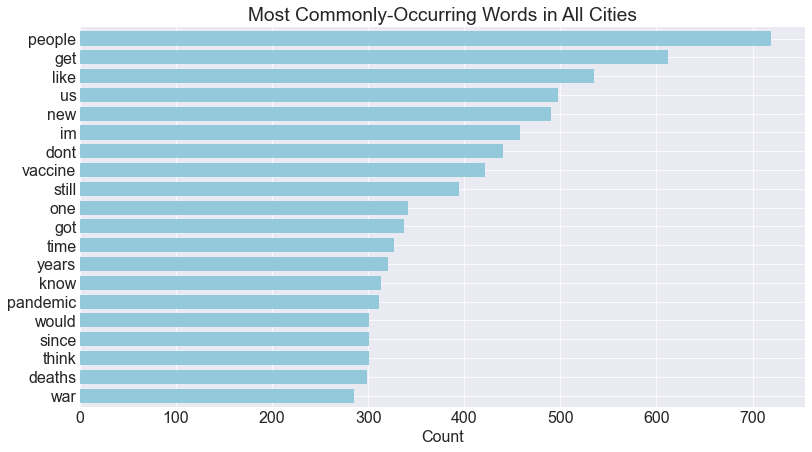

In [48]:
word_counts.All.sort_values(ascending=False).head(20).sort_values(ascending=True).plot.barh(width=0.75)
plt.gca().set(title='Most Commonly-Occurring Words in All Cities', xlabel='Count');

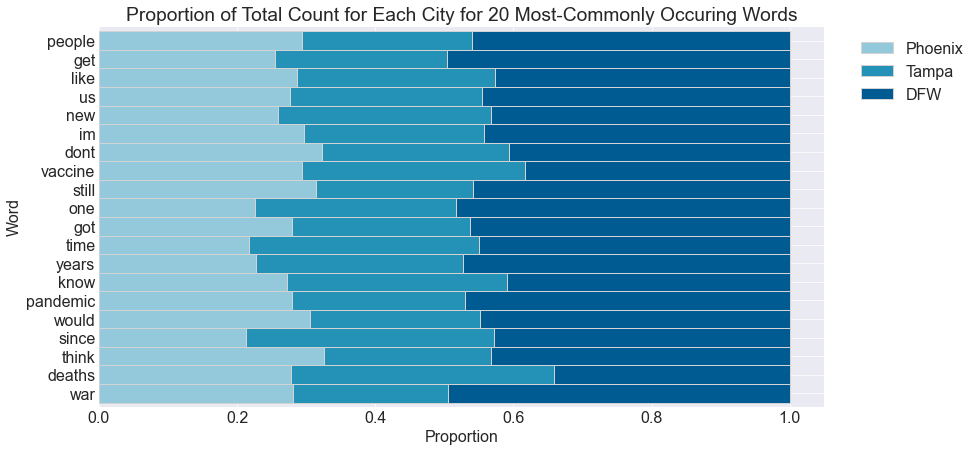

In [49]:
e.plot_stacked_all(word_counts)

### Word Counts and Proportions for each City

#### Phoenix

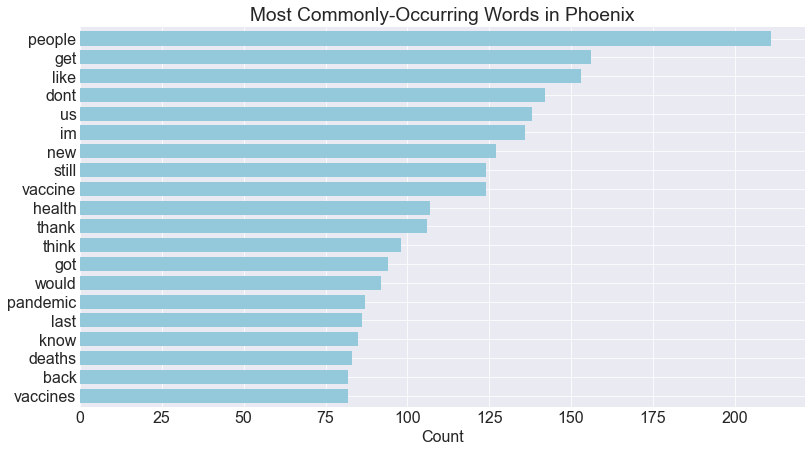

In [50]:
word_counts.Phoenix.sort_values(ascending=False).head(20).sort_values(ascending=True).plot.barh(width=0.75)
plt.gca().set(title='Most Commonly-Occurring Words in Phoenix', xlabel='Count');

<Figure size 1152x648 with 0 Axes>

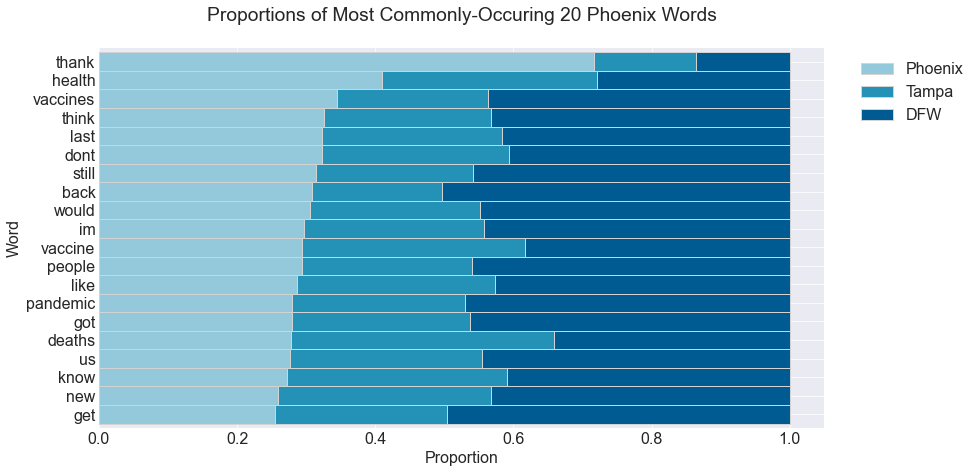

In [51]:
e.plot_stacked_bar(word_counts, 'Phoenix')

#### Tampa

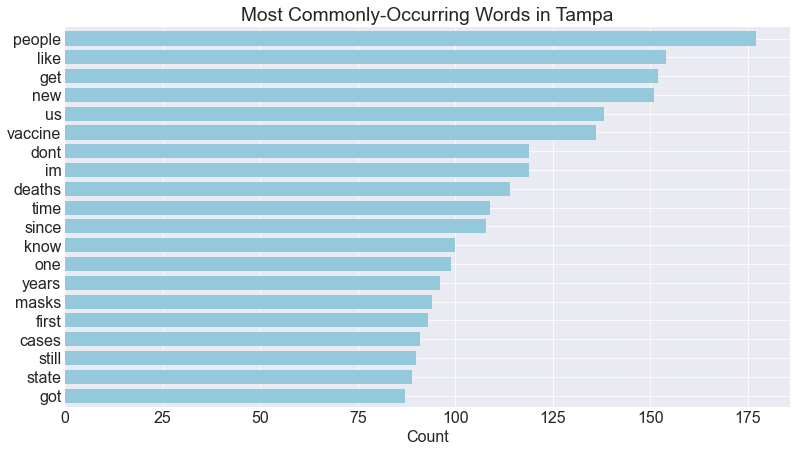

In [52]:
word_counts.Tampa.sort_values(ascending=False).head(20).sort_values(ascending=True).plot.barh(width=0.75)
plt.gca().set(title='Most Commonly-Occurring Words in Tampa', xlabel='Count');

<Figure size 1152x648 with 0 Axes>

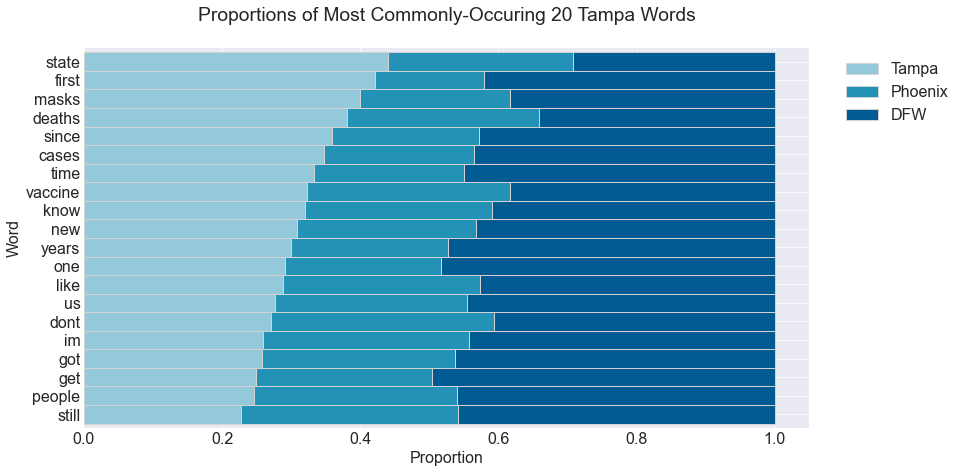

In [53]:
e.plot_stacked_bar(word_counts, 'Tampa')

#### DFW

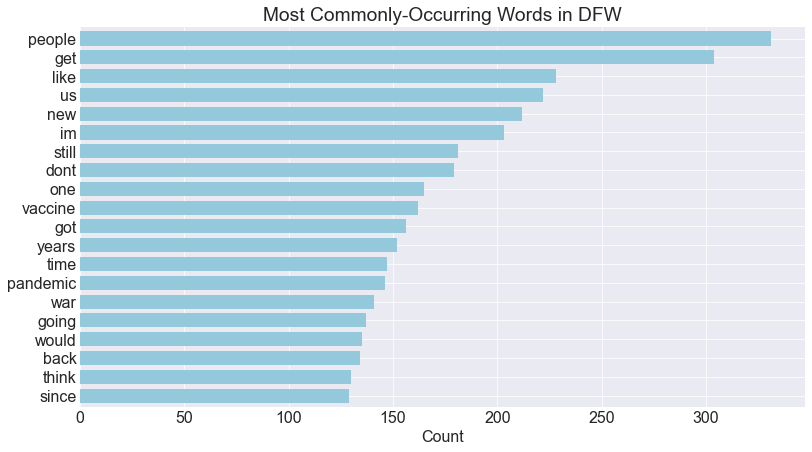

In [54]:
word_counts.DFW.sort_values(ascending=False).head(20).sort_values(ascending=True).plot.barh(width=0.75)
plt.gca().set(title='Most Commonly-Occurring Words in DFW', xlabel='Count');

<Figure size 1152x648 with 0 Axes>

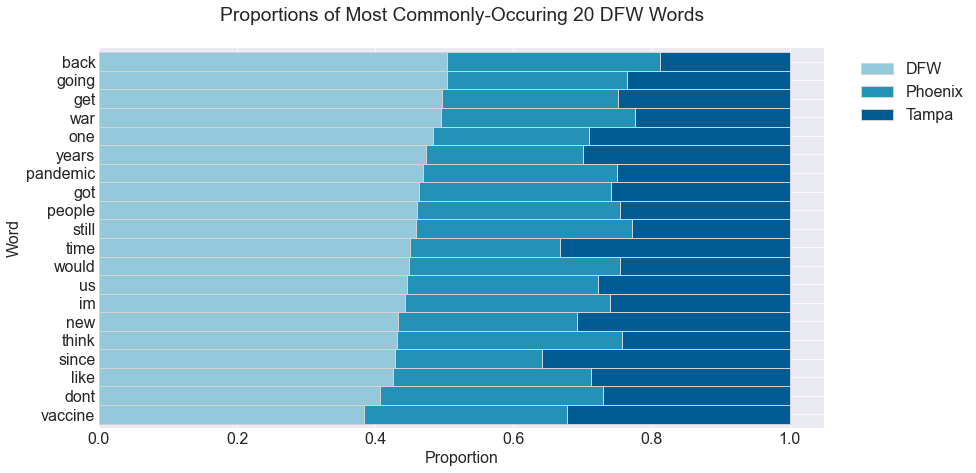

In [55]:
e.plot_stacked_bar(word_counts, 'DFW')

### Bigrams

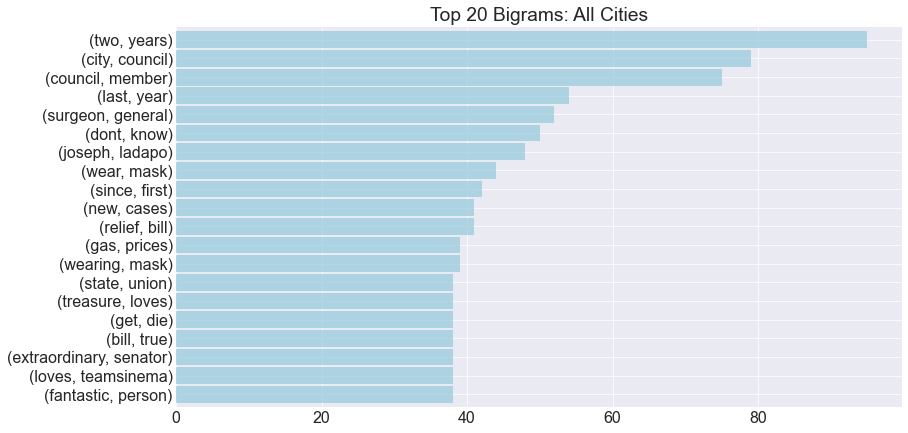

In [56]:
e.bigram_count(all_words, city_name='All Cities')

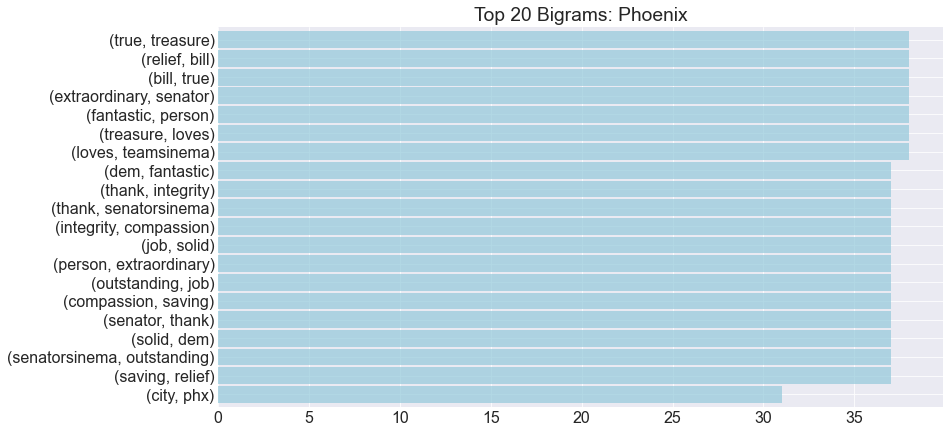

In [57]:
e.bigram_count(phoenix_words, city_name='Phoenix')

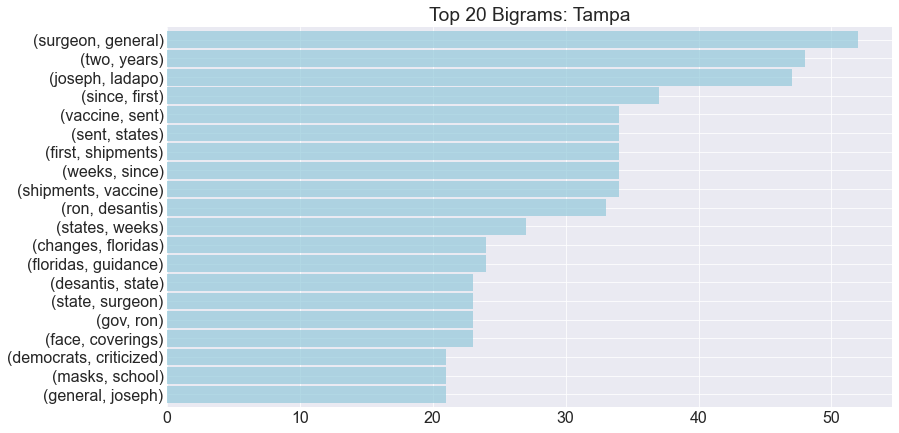

In [58]:
e.bigram_count(tampa_words, city_name='Tampa')

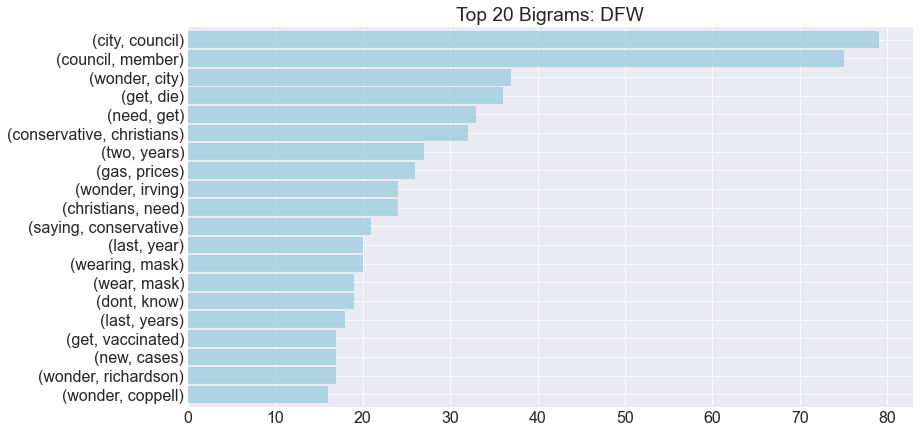

In [59]:
e.bigram_count(dfw_words, city_name='DFW')

### Trigrams

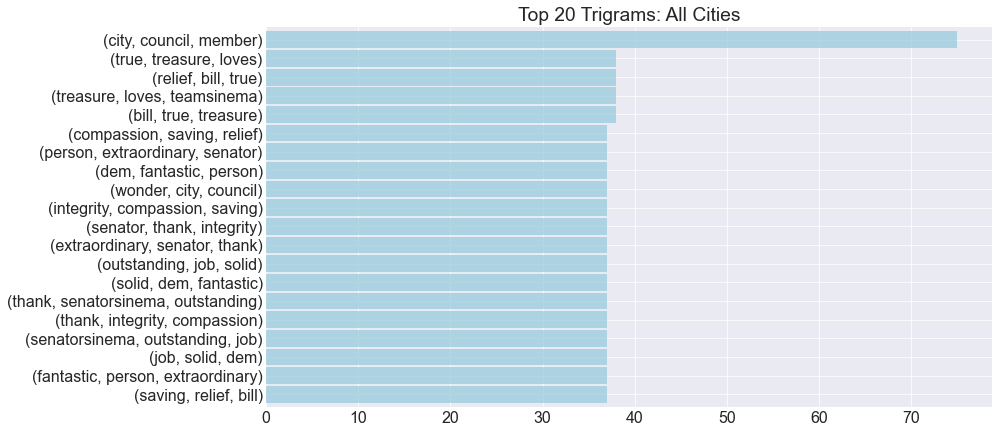

In [60]:
e.trigram_count(all_words, city_name='All Cities')

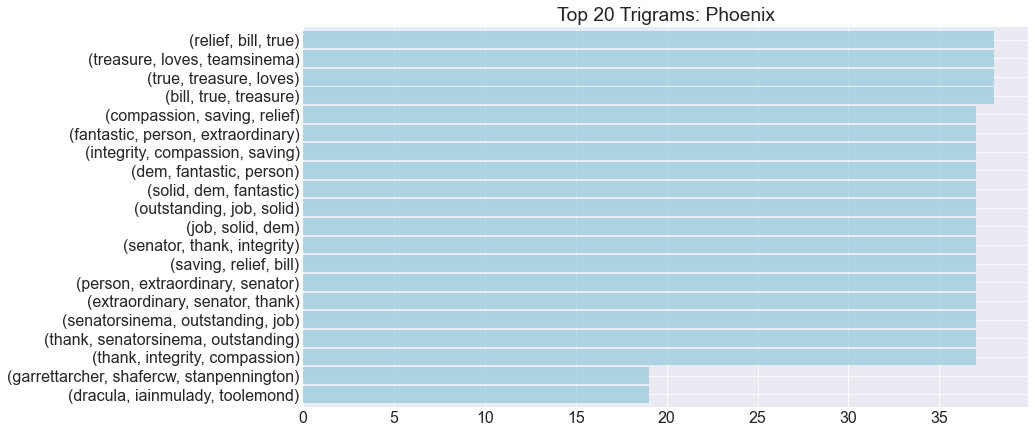

In [61]:
e.trigram_count(phoenix_words, city_name='Phoenix')

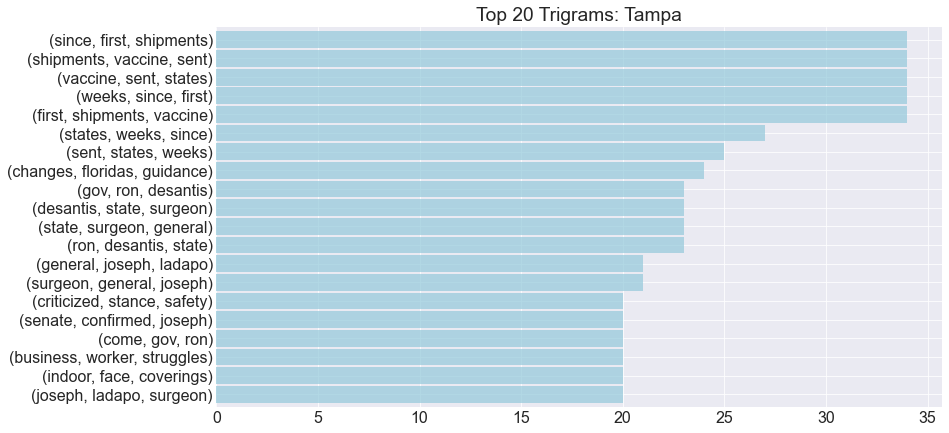

In [62]:
e.trigram_count(tampa_words, city_name='Tampa')

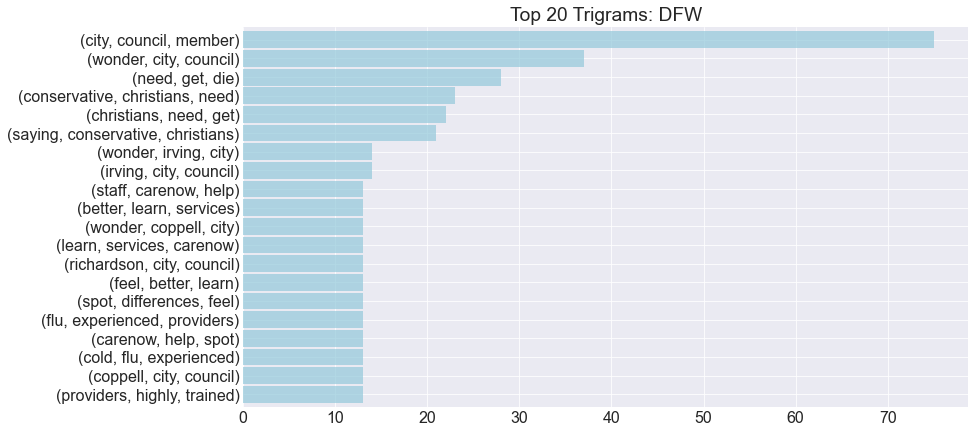

In [63]:
e.trigram_count(dfw_words, city_name='DFW')

### Word Clouds

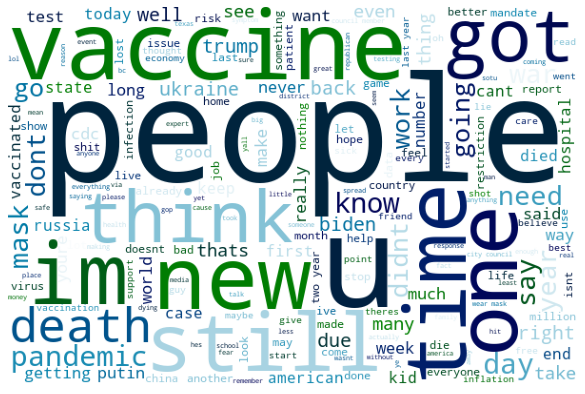

In [64]:
wc_all = WordCloud(background_color='white', colormap='ocean_r', height=400, width=600).generate(all_words)
plt.imshow(wc_all)
plt.axis('off')
plt.show()

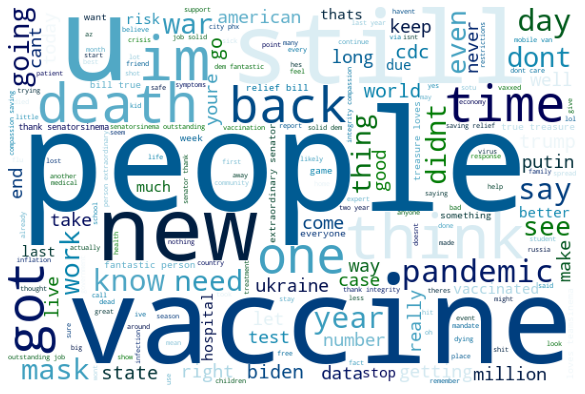

In [65]:
wc_phoenix = WordCloud(background_color='white', colormap='ocean_r', height=400, width=600).generate(phoenix_words)
plt.imshow(wc_phoenix)
plt.axis('off')
plt.show()

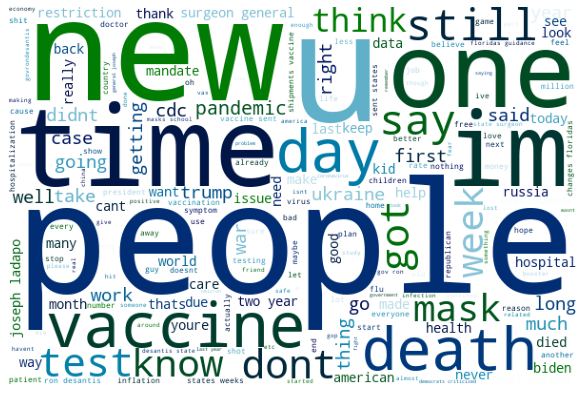

In [66]:
wc_tampa = WordCloud(background_color='white', colormap='ocean_r', height=400, width=600).generate(tampa_words)
plt.imshow(wc_tampa)
plt.axis('off')
plt.show()

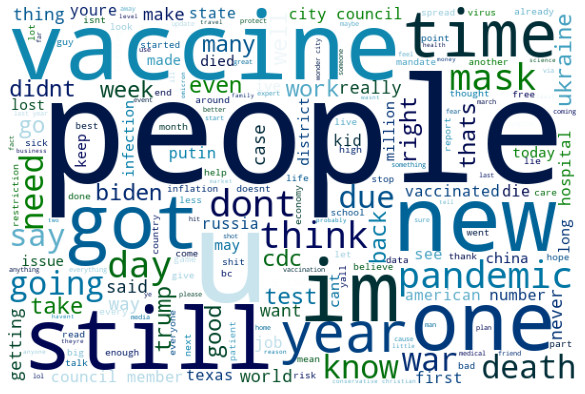

In [67]:
wc_dfw = WordCloud(background_color='white', colormap='ocean_r', height=400, width=600).generate(dfw_words)
plt.imshow(wc_dfw)
plt.axis('off')
plt.show()

### Word and Character Counts

In [68]:
# use spark to combine all cites into single df
pho_df = clean_phoenix_df.withColumn('city', F.lit('Phoenix'))
tam_df = clean_tampa_df.withColumn('city', F.lit('Tampa'))
df_df = clean_dfw_df.withColumn('city', F.lit('DFW'))
temp_df = pho_df.union(tam_df)
all_df = temp_df.union(df_df)
print(f"Double check we aren't losing any records: ")
all_df.groupBy('city').count().show()

Double check we aren't losing any records: 
+-------+-----+
|   city|count|
+-------+-----+
|Phoenix| 2019|
|  Tampa| 2167|
|    DFW| 3501|
+-------+-----+



In [69]:
# create new columns for char_count, word_count, ave_word_lenth
# char_count
all_df = all_df.withColumn('char_count', F.length(F.col('full_text')))

In [70]:
# word count
all_df = all_df.withColumn('word_count', F.split(F.col('full_text'), ' '))
all_df = all_df.withColumn('word_count', F.size(F.col('word_count')))

In [71]:
# average word length
all_df = all_df.withColumn('ave_word_length', F.col('char_count') / F.col('word_count'))
all_df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+-------+----------+----------+-----------------+
|          created_at|           full_text|         basic_clean|           tokenized|               clean|   city|char_count|word_count|  ave_word_length|
+--------------------+--------------------+--------------------+--------------------+--------------------+-------+----------+----------+-----------------+
|Wed Mar 02 04:14:...|@DyessRigel @hjel...|dyessrigel hjelle...|dyessrigel hjelle...|dyessrigel hjelle...|Phoenix|       254|        38|6.684210526315789|
|Wed Mar 02 04:14:...|@DonaldJTrumpJr S...|donaldjtrumpjr sh...|donaldjtrumpjr sh...|donaldjtrumpjr sh...|Phoenix|        88|        14|6.285714285714286|
|Wed Mar 02 04:10:...|@RenegadeofCav @k...|renegadeofcav kil...|renegadeofcav kil...|renegadeofcav kil...|Phoenix|       255|        44|5.795454545454546|
|Wed Mar 02 04:08:...|@laurenboebert Sa...|laurenboebert sav...|lauren

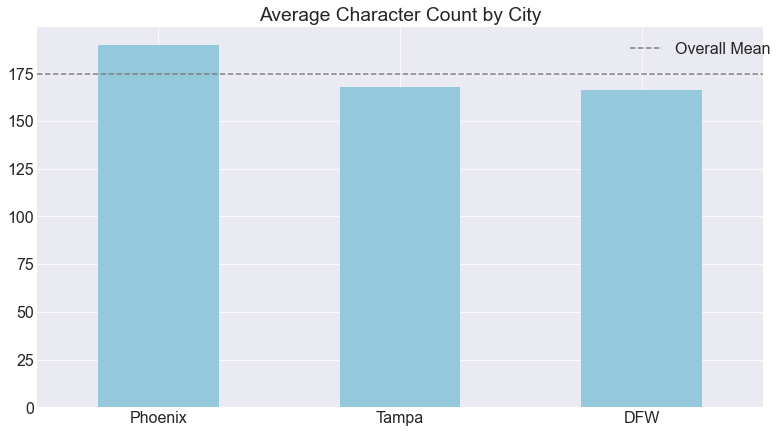

In [72]:
# use different syntax to alias group by column
ave_char_df = all_df.groupBy('city').agg(F.mean('char_count').alias('ave_char_count')).toPandas()
ave_char_df.set_index('city').ave_char_count.plot.bar(label='')
plt.title('Average Character Count by City')
plt.xlabel('')
# plt.ylabel('Average Character Count')
plt.axhline(y=ave_char_df.ave_char_count.mean(), color='gray', ls='--', label = 'Overall Mean')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor= (1.03,1));

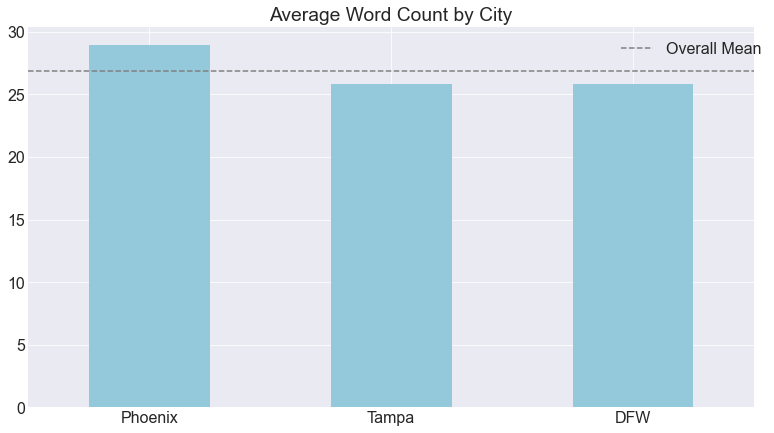

In [73]:
# use different syntax to alias group by column
ave_word_df = all_df.groupBy('city').agg(F.mean('word_count').alias('ave_word_count')).toPandas()
ave_word_df.set_index('city').ave_word_count.plot.bar(label='')
plt.title('Average Word Count by City')
plt.xlabel('')
# plt.ylabel('Average Character Count')
plt.axhline(y=ave_word_df.ave_word_count.mean(), color='gray', ls='--', label = 'Overall Mean')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor= (1.03,1));

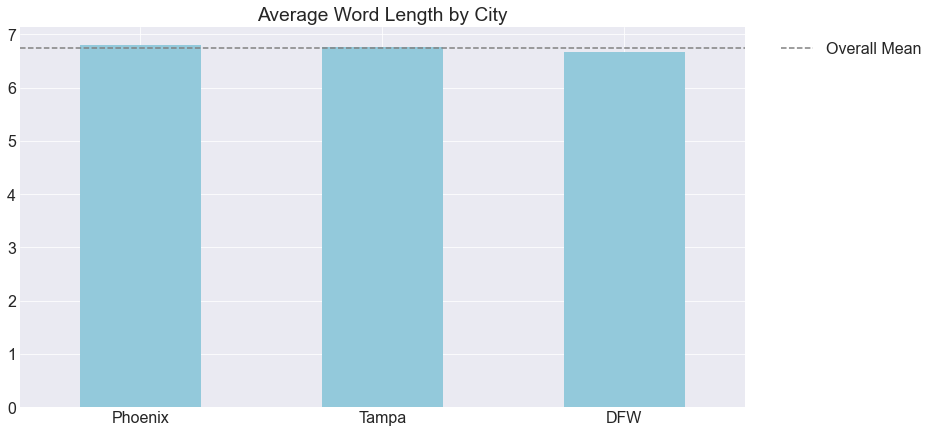

In [74]:
# use different syntax to alias group by column
ave_word_length_df = all_df.groupBy('city').agg(F.mean('ave_word_length').alias('ave_word_length')).toPandas()
ave_word_length_df.set_index('city').ave_word_length.plot.bar(label='')
plt.title('Average Word Length by City')
plt.xlabel('')
# plt.ylabel('Average Character Count')
plt.axhline(y=ave_word_length_df.ave_word_length.mean(), color='gray', ls='--', label = 'Overall Mean')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor= (1.03,1));

## Sentiment Analysis

### NLTK UDF

In [75]:
sia = sent.SentimentIntensityAnalyzer()
def get_sentiment(some_string):
  return sia.polarity_scores(some_string)['compound']

In [76]:
# create the udf from the python function
get_sentiment_udf = F.udf(get_sentiment, DoubleType())

In [77]:
all_df = all_df.withColumn('sentiment_score', get_sentiment_udf('full_text'))

### Compare Cities

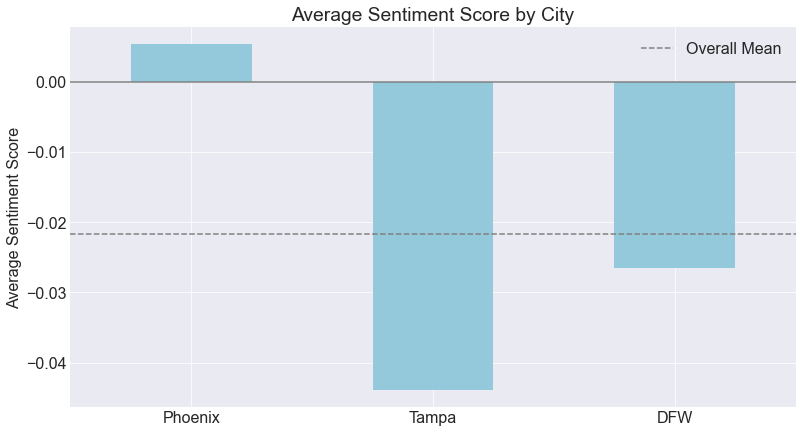

In [78]:
# group bys with aggregations to see how cities stack up
# mean
ave_sent_df = all_df.groupBy('city').agg(F.mean('sentiment_score').alias('ave_sentiment_score')).toPandas()
ave_sent_df.set_index('city').ave_sentiment_score.plot.bar(title='Average Sentiment Score by City', xlabel='', ylabel='Average Sentiment Score', label='')
plt.axhline(y=ave_sent_df.ave_sentiment_score.mean(), color='gray', ls='--', label = 'Overall Mean')
plt.axhline(y=0, color='gray', label = '')
plt.legend()
plt.xticks(rotation=0);

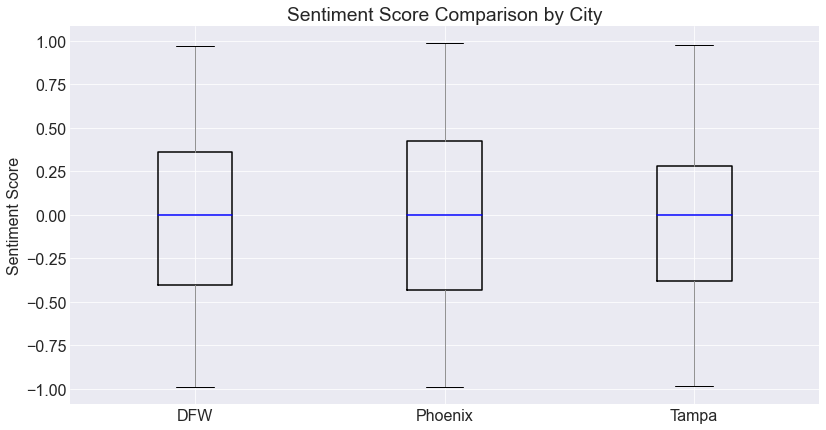

In [79]:
# create box plots for each city to visualize above info
all_df_pd = all_df.toPandas()
boxprops = dict(color="black",linewidth=1.5)
medianprops = dict(color="blue",linewidth=1.5)
all_df_pd.boxplot(column='sentiment_score', by='city', boxprops=boxprops, medianprops=medianprops)
plt.suptitle('')
plt.gca().set(title='Sentiment Score Comparison by City', xlabel='', ylabel='Sentiment Score');

### Look at Positive, Neutral, Negative Proportions for each City

In [80]:
# split df into positive and negative tweets
neutral_df = all_df.where(F.col('sentiment_score') == 0)
positive_df = all_df.where(F.col('sentiment_score') > 0)
negative_df = all_df.where(F.col('sentiment_score') < 0)

# group by city
neu_df = neutral_df.groupby('city').agg(F.count('full_text').alias('neutral_count')).toPandas()
pos_df = positive_df.groupby('city').agg(F.count('full_text').alias('positive_count')).toPandas()
neg_df = negative_df.groupby('city').agg(F.count('full_text').alias('negative_count')).toPandas()
a_df = all_df.groupby('city').agg(F.count('full_text').alias('total_count')).toPandas()

# combine all these pandas dfs into a single to create plots and compare
# make the city the index for all
neu_df.set_index('city', inplace=True)
neg_df.set_index('city', inplace=True)
pos_df.set_index('city', inplace=True)
a_df.set_index('city', inplace=True)
total_df = pd.concat([neg_df, neu_df, pos_df, a_df], axis=1)
total_df

,negative_count,neutral_count,positive_count,total_count
city,,,,
Phoenix,795,398,826,2019
Tampa,878,540,749,2167
DFW,1396,805,1300,3501


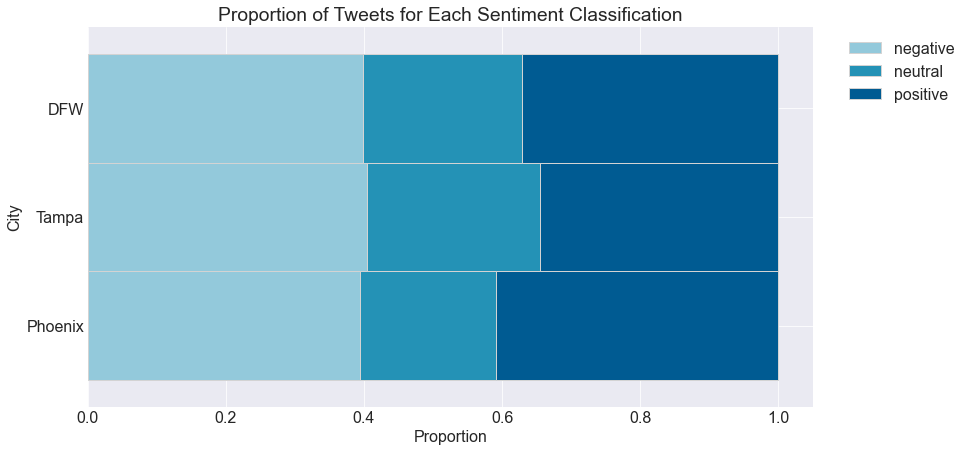

In [81]:
# create a plot similar to that of word proportions where you can see the proportion of each category for each city
(total_df
  .rename(columns={'neutral_count' : 'neutral', 'negative_count' : 'negative', 'positive_count' : 'positive'})
  .apply(lambda row: row / row['total_count'], axis=1)
  .drop(columns = 'total_count')
  .plot.barh(stacked=True, width=1, ec='lightgrey')
)
plt.title('Proportion of Tweets for Each Sentiment Classification')
plt.legend(bbox_to_anchor= (1.03,1))
plt.xlabel('Proportion')
plt.ylabel('City');

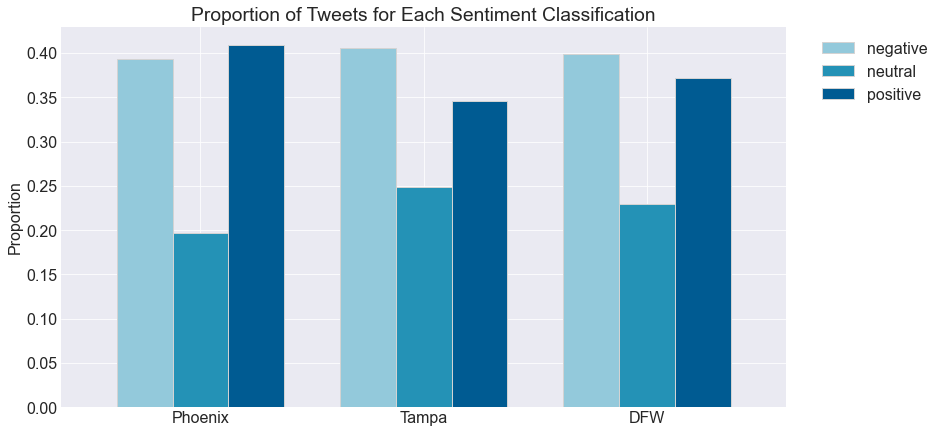

In [82]:
# create a plot similar to that of word proportions where you can see the proportion of each category for each city
(total_df
  .rename(columns={'neutral_count' : 'neutral', 'negative_count' : 'negative', 'positive_count' : 'positive'})
  .apply(lambda row: row / row['total_count'], axis=1)
  .drop(columns = 'total_count')
  .plot.bar(width=0.75, ec='lightgrey')
)
plt.title('Proportion of Tweets for Each Sentiment Classification')
plt.legend(bbox_to_anchor= (1.03,1))
plt.xticks(rotation=0);
plt.xlabel('')
plt.ylabel('Proportion');

### Export data

In [83]:
all_df_pd = all_df.toPandas()

In [84]:
time_stamp

'2022-03-01_21-24-03'

In [85]:
# all_df_pd.to_json(f'{time_stamp}_all_cities.json', orient='records')

In [86]:
all_df_pd.to_json(f'data/{time_stamp}/{time_stamp}_all_cities.json', orient='records')

In [87]:
spark.stop()